<a href="https://colab.research.google.com/github/ThrupthiAnn/CVSummerSchool2021/blob/main/Beyond_Supervised/4_Weakly_Supervised_Learning_Finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weakly Supervised Learning (WSL)

The class of machine learning algorithms which learn complex machine learning models using *weak* or *in-exact* labels are called as *weakly supervised learning*. These weak labels are often easy to obtain from web in form of meta-data. As a concrete example in the figure below, the hope is to learn an object detector or a segmenter when the only information present in form of annotations is whether an object is present in an image or not. 
<img src="images/fig1.png">

## General Method for Solving WSL
There are various approaches described in the literature for solving the problem WSL, including heur. The most traditional among them is **Multiple Instance Learning (MIL)**. 
### Multiple Instance Learning - Concept
The key idea behind MIL is that instead of representing each image by a single feature vector, it represents them by a collection or a set of feature vectors, i.e. by means of multiple instances. So the setting is that we have sets or *bag* of instances (feature vectors) to represent every image, but we still have the label or annotation for the individual bag (instead of the instances). Formally, we have a set of bags with their corresponding labels. A bag is labeled positive if at least one instance in it corresponds to the *positive concept*. We look for a a discriminant, where all patterns from negative bags are on the negative halfspace and at least one pattern from every positive bag is on the positive halfspace, and across all positive bags, some patterns should be in positive halfspace which prevents the positive bag to turn into negative. Graphically, <img src="images/fig2.png" width=350>
Briefly, MIL aims to (a) classify new and previously unseen bags as accurate as possible, and (b) discover a “concept” that determines the positive class. 
### MIL - Optimization
#### Notation 
Let us denote a bag with $X = \{x_1, x_2, \dots, x_K\}$, where $x_i$ are individual instaces of a particular bag. We assume that $K$ could vary with each bag. We denote a single binary label associated with a bag with $Y \in \{0,1\}$. We assume that each instance in the bag also has labels, $y_1, y_2, \dots, y_K$ which we *don't have access to*. We can re-write assumption of the MIL as,
$$Y = \begin{cases}0,\ \mathrm{iff}\ \sum_k y_k = 0 \\ 1,\ \mathrm{otherwise}\ \end{cases}$$ 
or the two statements in the above condition can be merged as, $Y = \max_k\{y_k\}$. 
#### MIL Approaches
In order to effectively learn from such a model, one optimizes log-likelihood function where the bag label is distributed according to the Bernaulli distribution with the parameters $\theta(X) \in [0,1]$, i.e. the probability of $Y = 1$ given the bag of instances. 
##### The Learning Objective
Given, (a) a transformation of instances using the function $f$, (b) combination of transformed instances using a symmetric function $\sigma$, and (c) transformation of combined instances using a function $g$, we define the MIL objective function as:
$$\min \{\hat{Y} - g(\sigma_{x_k}(f(x_k)))\}$$
where, $\hat{Y}$ is the ground truth label for the bag
##### Modeling MIL via Neural Networks
We consider r a class of transformations that are parameterized by neural networks $f_\psi(\cdot)$, with parameters $\psi$ that transforms $k$-th instance into a low dimension embedding, $h_k = f_\psi(x_k)$, where $h_k \in \cal{H}$ such that $\cal{H} = \mathbb{R}^M$. Eventually, the parameter $\theta(X)$ is determined by a transformation $g_\phi: \cal{H} \rightarrow [0,1]$. The function $g_\phi$ is also parameterized by a neural network with parameters $\phi$. The idea of parameterizing all transformations using neural networks is very appealing because the whole approach can be arbitrarily flexible and it can be trained end-to-end by backpropagation. We have seen till now the modeling of the two transformation function $f$ and $g$, which leaves us with modeling the combination function $\sigma$. 

**MIL Pooling: A naive approach - ** In literature many different combination function has been explored. The famous among them are the mean operator $z = \sum_{k=1}^K h_k$, the max operator $z = \max_{k=1, \dots, K}$\{h_k\} and log-sum-exponential operator. In neural network jargon, these operators are also known as pooling layers.

**Attention MIL: A learnable combination function - ** The mean, max and log-sum-exponential pooling are pre-defined and non-trainable choice of combination function. Attention mechanism tries to alleviate this problem by computing weighted average of the low-dimensional embeddings, where the weights are determined by the neural network. Formally, $$z = \sum_{k=1}^K \alpha_k h_k$$ where, $$\alpha_k = \frac{\exp\{W^T \tanh(h_k^T)\}}{\sum_{j=1}^K \exp\{W^T \tanh(h_j^T)\}}$$

# Practical: Finding5 - A Simple Weakly Supervised Object Detection Problem
<img src="images/fig3.jpg">

Let us see a practical use of MIL to detect object in a weakly supervised manner. We will see how this algorithm is modeled for a toy task which will hopefully give us insight into how we can apply the same in a in-the-wild detection setting. 

Consider the task of finding where the digit 5 is located in the synthetic image (a) below. 
<img src="images/fig4.png">

This synthetic image was generated by using the well known MNIST data set. Each image is of size $112 \times 112$ and contains a random number of $28 \times 28$  grayscale images taken from the MNIST data set. The number of digits in each image is Gaussian-distributed. The image is labeled positive (1) if at least one of the digits inside it contains the digit 5, otherwise it is labeled as negative (0). The task is to find where the digit 5 is located in the image (as shown in figure (b) above. 

In order to make our task simpler, assume that our image is of size $4 \times 4$ grid and the digits chosen from the MNIST data set are placed randomly in one of these 16 grid locations. We then linearize these grids and remove all the blank spaces as shown in figure below. Note that we can invert the process and so there is no loss of generality.
<img src="images/fig5.png">

This list now acts as an updated bag (and let's call it MNIST Bags data set) which is fed to the modified LeNet Architecture below.

### Imports

In [1]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

### Create MNIST-Bags dataset

In [2]:
# creating jumbled mnist class
class MnistBags(data_utils.Dataset):
    """
    This class creates MNIST-Bags 
    """
    def __init__(self, mean_bag_length=5, var_bag_length=2, num_bag=250, seed=1, train=True):
        self.target_number = 5 # The number we are interested in detecting [Try other numbers]
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.train = train

        self.r = np.random.RandomState(seed)

        self.num_in_train = 60000
        self.num_in_test = 10000

        if self.train:
            self.train_bags_list, self.train_labels_list = self._create_bags()
        else:
            self.test_bags_list, self.test_labels_list = self._create_bags()

    def _create_bags(self):
        if self.train:
            loader = data_utils.DataLoader(datasets.MNIST('.',
                                                          train=True,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_train,
                                           shuffle=False)
        else:
            loader = data_utils.DataLoader(datasets.MNIST('.',
                                                          train=False,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_test,
                                           shuffle=False)

        for (batch_data, batch_labels) in loader:
            all_imgs = batch_data
            all_labels = batch_labels

        bags_list = []
        labels_list = []

        for i in range(self.num_bag):
            bag_length = np.int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))
            if bag_length < 1:
                bag_length = 1

            if self.train:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_train, bag_length))
            else:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_test, bag_length))

            labels_in_bag = all_labels[indices]
            labels_in_bag = labels_in_bag == self.target_number

            bags_list.append(all_imgs[indices])
            labels_list.append(labels_in_bag)

        return bags_list, labels_list

    def __len__(self):
        if self.train:
            return len(self.train_labels_list)
        else:
            return len(self.test_labels_list)

    def __getitem__(self, index):
        if self.train:
            bag = self.train_bags_list[index]
            label = [max(self.train_labels_list[index]), self.train_labels_list[index]]
        else:
            bag = self.test_bags_list[index]
            label = [max(self.test_labels_list[index]), self.test_labels_list[index]]

        return bag, label

### Define MIL Net with LeNet Architecture. Let's call it MILeNet

In [3]:
class MILeNet(nn.Module):
    """
    This class modifies a basic LeNet architecture for the task of weakly supervised detection problem.
    """
    def __init__(self, choice):
        super(MILeNet, self).__init__()
        # Define hyper-parameters
        self.L = 500
        self.D = 128
        self.K = 1
        self.choice = choice    # defines the choice of mil-pooling layer
        
        # Define convolutional layers
        self.conv_feats = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Define linear layers
        self.lin_feats = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU()
        )
        
        # Define attention layers
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        
        # Define layers
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.squeeze(0)
        
        H = self.conv_feats(x)           # Nx50x4x4
        H = H.view(-1, 50 * 4 * 4)       # Nx800
        H = self.lin_feats(H)            # NxL
        
        s_pool, s_weight = self.mil_pooling(H, self.choice)
        
        y_prob = self.classifier(s_pool)
        y_hat = torch.ge(y_prob, 0.5).float()
        
        
        return y_prob, y_hat, s_weight
    
    def mil_pooling(self, H, choice):
        '''
        function for computing multiple instance pooling operation given a particular choice.
        '''
        if choice == 'mean':
            s_pool = torch.mean(H, dim=0, keepdim=True)        # 1xL
            s_weight = torch.mean(H, dim=1, keepdim=True)      # Nx1
            s_weight = torch.transpose(s_weight, 1, 0)         # 1xN
            s_weight = F.softmax(s_weight, dim=1)              # Softmax over N
        elif choice == 'max':
            s_pool,_ = torch.max(H, dim=0, keepdim=True)       # 1xL
            s_weight = torch.mean(H, dim=1, keepdim=True)      # Nx1
            s_weight = torch.transpose(s_weight, 1, 0)         # 1xN
            s_weight = F.softmax(s_weight, dim=1)              # Softmax over N
        elif choice == 'lse':
            s_pool = self.logsumexp(H, dim=0, keepdim=True)    # 1xL
            s_weight = torch.mean(H, dim=1, keepdim=True)      # Nx1
            s_weight = torch.transpose(s_weight, 1, 0)         # 1xN
            s_weight = F.softmax(s_weight, dim=1)              # Softmax over N
        elif choice == 'attention':
            s_weight = self.attention(H)                       # NxK; K=1
            s_weight = torch.transpose(s_weight, 1, 0)         # KxN
            s_weight = F.softmax(s_weight, dim=1)              # softmax over N
            s_pool = torch.mm(s_weight, H)                     # KxL
        else:
            raise ValueError('Wrong choice of MIL Pooling selected')
            
        return s_pool, s_weight
    
    def logsumexp(self, inputs, dim=None, keepdim=False):
        """
        Numerically stable logsumexp.
        """
        s, _ = torch.max(inputs, dim=dim, keepdim=True)
        outputs = s + (inputs - s).exp().sum(dim=dim, keepdim=True).log()
        if not keepdim:
            outputs = outputs.squeeze(dim)
        return outputs
    
    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, f_weight = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, f_weight

### The train and test functions

In [4]:
def train(epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, label) in enumerate(train_loader):
        bag_label = label[0]
        data, bag_label = data.cuda(), bag_label.cuda()

        # reset gradients
        optimizer.zero_grad()
        
        # calculate loss and metrics
        loss, _ = model.calculate_objective(data, bag_label)
        train_loss += loss.item()
        error, _ = model.calculate_classification_error(data, bag_label)
        train_error += error
        
        # backward pass
        loss.backward()
        
        # step
        optimizer.step()

    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)

    print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss, train_error))

In [5]:
def test():
    model.eval()
    test_loss = 0.
    test_error = 0.
    for batch_idx, (data, label) in enumerate(test_loader):
        bag_label = label[0]
        instance_labels = label[1]
        data, bag_label = data.cuda(), bag_label.cuda()
        
        loss, feature_weights = model.calculate_objective(data, bag_label)
        test_loss += loss.item()
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        test_error += error

        if batch_idx < 5:  # plot bag labels and instance labels for first 5 bags of the test set
            bag_level = (bag_label.cpu().data.numpy()[0], int(predicted_label.cpu().data.numpy()[0][0]))
            instance_level = list(zip(instance_labels.numpy()[0].tolist(),
                                 np.round(feature_weights.cpu().data.numpy()[0], decimals=3).tolist()))

            print('\nTrue Bag Label, Predicted Bag Label: {}\n'
                  'True Instance Labels, Feature Weights: {}'.format(bag_level, instance_level))
            
            
            ####
            ## Plot the heatmap
            nb_instances = data.shape[1]

            data = data.squeeze(0)

            ind = [x+1 for x in range(nb_instances)]
            score = feature_weights.cpu().data.numpy()[0]
            show_digits = torch.zeros(28, 28*nb_instances)
            show_maps = np.zeros((28, 28*nb_instances), dtype=np.float)
            for i in range(nb_instances):
                digit = data[i,:,:,:].squeeze(0)
                show_digits[:, i*28:(i+1)*28] = digit
                show_maps[:, i*28:(i+1)*28].fill(score[i])
            
            ## plot
            plt.figure(batch_idx+1)

            plt.subplot(2,1,1)
            plt.imshow(show_digits)
            plt.axis('off')
            
            plt.subplot(2,1,2)
            plt.imshow(show_maps, cmap=plt.cm.hot)
            # plt.colorbar()
            plt.show()
            
            print(100*'#')

    test_error /= len(test_loader)
    test_loss /= len(test_loader)

    print('\nTest Set, Loss: {:.4f}, Test error: {:.4f}'.format(test_loss, test_error))

### Main Function

Load Train and Test Set



Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Init Model
Start Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1, Loss: 0.5329, Train error: 0.2560
Epoch: 2, Loss: 0.2250, Train error: 0.0710
Epoch: 3, Loss: 0.1070, Train error: 0.0350
Epoch: 4, Loss: 0.0999, Train error: 0.0240
Epoch: 5, Loss: 1.5411, Train error: 0.1400
Epoch: 6, Loss: 3.8108, Train error: 0.3310
Epoch: 7, Loss: 3.8108, Train error: 0.3310
Epoch: 8, Loss: 3.8108, Train error: 0.3310
Epoch: 9, Loss: 3.8108, Train error: 0.3310
Epoch: 10, Loss: 3.8108, Train error: 0.3310
Epoch: 11, Loss: 3.8108, Train error: 0.3310
Epoch: 12, Loss: 3.2674, Train error: 0.2920
Epoch: 13, Loss: 0.1095, Train error: 0.0340
Epoch: 14, Loss: 0.0816, Train error: 0.0300
Epoch: 15, Loss: 0.0848, Train error: 0.0190
Epoch: 16, Loss: 0.0658, Train error: 0.0220
Epoch: 17, Loss: 0.0262, Train error: 0.0070
Epoch: 18, Loss: 0.0497, Train error: 0.0140
Epoch: 19, Loss: 0.0176, Train error: 0.0030
Epoch: 20, Loss: 0.1151, Train error: 0.0200
Start Testing

True Bag Label, Predicted Bag Label: (True, 1)
True Instance Labels, Feature Weights: [(False,

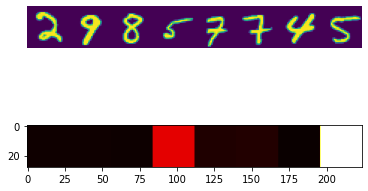

####################################################################################################

True Bag Label, Predicted Bag Label: (True, 1)
True Instance Labels, Feature Weights: [(False, 0.12200000137090683), (False, 0.12399999797344208), (True, 0.7549999952316284)]


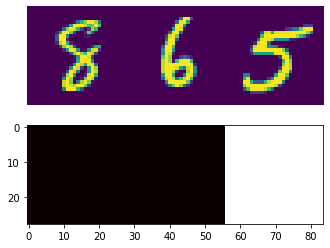

####################################################################################################

True Bag Label, Predicted Bag Label: (True, 1)
True Instance Labels, Feature Weights: [(True, 0.3919999897480011), (False, 0.14300000667572021), (False, 0.14300000667572021), (False, 0.1550000011920929), (False, 0.16699999570846558)]


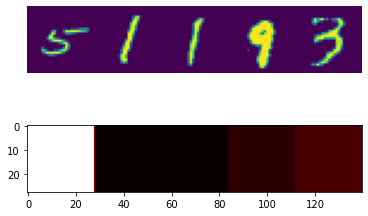

####################################################################################################

True Bag Label, Predicted Bag Label: (False, 0)
True Instance Labels, Feature Weights: [(False, 1.0)]


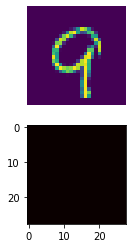

####################################################################################################

True Bag Label, Predicted Bag Label: (True, 1)
True Instance Labels, Feature Weights: [(False, 0.22699999809265137), (True, 0.31299999356269836), (False, 0.1809999942779541), (False, 0.2800000011920929)]


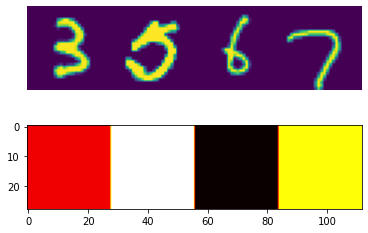

####################################################################################################

Test Set, Loss: 0.2480, Test error: 0.0400


In [6]:
if __name__ == "__main__":
    ## Load the train and the test set
    print('Load Train and Test Set')
    loader_kwargs = {'num_workers': 1, 'pin_memory': True} 

    train_loader = data_utils.DataLoader(MnistBags(num_bag=1000,
                                                   train=True),
                                         batch_size=1,
                                         shuffle=True,
                                         **loader_kwargs)

    test_loader = data_utils.DataLoader(MnistBags(num_bag=50,
                                                  train=False),
                                        batch_size=1,
                                        shuffle=False,
                                        **loader_kwargs)
    
    ## Initialize the model
    print('Init Model')
    choice = 'mean'    # select one in 'mean', 'max', 'lse', 'attention'
    model = MILeNet(choice)
    model.cuda()
    optimizer = optim.Adam(model.parameters(), weight_decay=10e-5)
    
    ## Start training
    print('Start Training')
    nb_epochs = 20        # number of training epochs
    for epoch in range(1, nb_epochs + 1):
        train(epoch)
    print('Start Testing')
    test()

### Excercise

1. Select different pooling layers and observe the effect on accuracy.
2. Change the hyper-parameters like bag size (num_bags and not the batch size), epochs, and bag length. See the effect on accuracy for each set of hyper-parameter values.
3. See the results for other digits (apart from 5).